# Install Java and Spark into Colab environment

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [3]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark

# Import the data and create a Spark dataframe

This dataset is public and comes from [UCI ML Repo](https://archive.ics.uci.edu/ml/datasets/Adult). "This data derives from census data and consists of information about 48842 individuals and their annual income. You can use this information to predict if an individual earns <=50K or >50k a year. The dataset consists of both numeric and categorical variables."

https://docs.databricks.com/_static/notebooks/binary-classification.html

In [4]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

In [5]:
schema = StructType([
  StructField("age", DoubleType(), False),
  StructField("workclass", StringType(), False),
  StructField("fnlwgt", DoubleType(), False),
  StructField("education", StringType(), False),
  StructField("education_num", DoubleType(), False),
  StructField("marital_status", StringType(), False),
  StructField("occupation", StringType(), False),
  StructField("relationship", StringType(), False),
  StructField("race", StringType(), False),
  StructField("sex", StringType(), False),
  StructField("capital_gain", DoubleType(), False),
  StructField("capital_loss", DoubleType(), False),
  StructField("hours_per_week", DoubleType(), False),
  StructField("native_country", StringType(), False),
  StructField("income", StringType(), False)
])

In [9]:
!ls ../adult_data

adult.data


In [14]:
dataset = spark.read.format("csv").schema(schema).load("../adult_data/adult.data")

cols = dataset.columns

In [19]:
dataset.show(10)

+----+-----------------+--------+----------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|      marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+--------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0|        State-gov| 77516.0| Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-g

In [18]:
dataset.show(5, truncate=False)

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age |workclass        |fnlwgt  |education |education_num|marital_status     |occupation        |relationship  |race  |sex    |capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0| State-gov       |77516.0 | Bachelors|13.0         | Never-married     | Adm-clerical     | Not-in-family| White| Male  |2174.0      |0.0         |40.0          | United-States| <=50K|
|50.0| Self-emp-not-inc|83311.0 | Bachelors|13.0         | Married-civ-spouse| Exec-managerial  | Husband      | White| Male  |0.0         |0.0         |13.0          | United-States| <=50K|
|38.0| Private         |215646.0| HS-grad  |9

# Practice commands

### Display only 3 columns

In [21]:
dataset[['age', 'occupation', 'income']].show(7)

+----+------------------+------+
| age|        occupation|income|
+----+------------------+------+
|39.0|      Adm-clerical| <=50K|
|50.0|   Exec-managerial| <=50K|
|38.0| Handlers-cleaners| <=50K|
|53.0| Handlers-cleaners| <=50K|
|28.0|    Prof-specialty| <=50K|
|37.0|   Exec-managerial| <=50K|
|49.0|     Other-service| <=50K|
+----+------------------+------+
only showing top 7 rows



### Get the total count of people making more or less than $50k by level of education.

In [26]:
dataset.groupby('education', 'income').count().show(5)

+----------+------+-----+
| education|income|count|
+----------+------+-----+
|      11th|  >50K|   60|
|      12th| <=50K|  400|
| Doctorate| <=50K|  107|
|   Masters|  >50K|  959|
|      10th| <=50K|  871|
+----------+------+-----+
only showing top 5 rows



### Get the average number of work hours per week by country

In [35]:
dataset.groupby('native_country').mean('hours_per_week').show(10)

+-------------------+-------------------+
|     native_country|avg(hours_per_week)|
+-------------------+-------------------+
| Dominican-Republic|  42.47142857142857|
|            Ireland| 42.416666666666664|
|               Cuba|   39.1578947368421|
|          Guatemala|          39.234375|
|               Iran|  43.97674418604651|
|             Taiwan|  38.88235294117647|
|        El-Salvador|  36.79245283018868|
|      United-States|  40.44775454233802|
|              South|            42.4125|
|              Japan| 43.693548387096776|
+-------------------+-------------------+
only showing top 10 rows



### What country is represenated the most in the dataset?

In [44]:
dataset.toPandas()['native_country'].value_counts()[:5]

 United-States    29170
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
Name: native_country, dtype: int64

### Display rows for those 40 years old or younger.

In [49]:
dataset.filter("age <= 40").show(5)

+----+----------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age| workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+----------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0| State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|38.0|   Private|215646.0|   HS-grad|          9.0|           Divorced| Handlers-cleaners| Not-in-family| White|   Male|         0.0|         0.0|          40.0| United-States| <=50K|
|28.0|   Private|338409.0| Bachelors|         13.0| Married-civ-spouse|    Prof-

### Display younger persons only living within the USA

In [56]:
dataset.filter( (dataset.age <= 40) & (dataset['native_country'] ==" United-States") ).show(8, truncate=False)  

+----+-----------------+--------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|age |workclass        |fnlwgt  |education    |education_num|marital_status     |occupation        |relationship  |race  |sex    |capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+-------------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0| State-gov       |77516.0 | Bachelors   |13.0         | Never-married     | Adm-clerical     | Not-in-family| White| Male  |2174.0      |0.0         |40.0          | United-States| <=50K|
|38.0| Private         |215646.0| HS-grad     |9.0          | Divorced          | Handlers-cleaners| Not-in-family| White| Male  |0.0         |0.0         |40.0          | United-States| <=50K|
|37.0| Private         |284582

### What are the unique values of relationship?

In [58]:
dataset.select('relationship').distinct()

relationship
Husband
Own-child
Not-in-family
Other-relative
Wife
Unmarried


### What is the average work hours per week by education in the USA?

In [68]:
dataset.filter("native_country == ' United-States'").groupby('education').mean('hours_per_week').orderBy('avg(hours_per_week)', ascending=False).withColumnRenamed("avg(hours_per_week)", "avg hours per week")

education,avg hours per week
Prof-school,47.48406374501992
Doctorate,47.40853658536585
Masters,44.16895874263261
Bachelors,42.709190096517
Assoc-voc,41.633048875096975
Assoc-acdm,40.65682281059063
HS-grad,40.59606266749124
7th-8th,39.06012024048096
Some-college,38.86186943620178
9th,38.03544303797468


In [69]:
from pyspark.sql.functions import min, max

### What is the least and most hours worked per week?

In [70]:
dataset.select(min(dataset['hours_per_week']), max(dataset['hours_per_week']))

min(hours_per_week),max(hours_per_week)
1.0,99.0


### Join another spark dataframe to the existing dataframe

In [77]:
filtered = dataset.filter(dataset['native_country'].isin([' Japan', ' Ireland']))
filtered.toPandas()['native_country'].value_counts()

 Japan      62
 Ireland    24
Name: native_country, dtype: int64

In [80]:
filtered.toPandas().sample(n=5).head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
11,50.0,Private,139464.0,Bachelors,13.0,Divorced,Prof-specialty,Unmarried,White,Female,0.0,0.0,36.0,Ireland,<=50K
39,41.0,Private,204682.0,HS-grad,9.0,Divorced,Craft-repair,Unmarried,White,Male,2174.0,0.0,40.0,Japan,<=50K
63,35.0,?,98080.0,Prof-school,15.0,Never-married,?,Not-in-family,Asian-Pac-Islander,Male,4787.0,0.0,45.0,Japan,>50K
49,40.0,Private,115932.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,60.0,Ireland,>50K
52,47.0,Private,133969.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,2885.0,0.0,65.0,Japan,<=50K


In [81]:
countries = spark.createDataFrame([['JP', ' Japan'],['IE', ' Ireland'],['US', ' United-States']], ["code", "country"])
countries.show()

+----+--------------+
|code|       country|
+----+--------------+
|  JP|         Japan|
|  IE|       Ireland|
|  US| United-States|
+----+--------------+



In [83]:
filtered = filtered.join(countries, filtered.native_country == countries.country, 'inner')
filtered.show(2)

+----+---------+--------+----------+-------------+-------------------+----------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+----+-------+
| age|workclass|  fnlwgt| education|education_num|     marital_status|      occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|code|country|
+----+---------+--------+----------+-------------+-------------------+----------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+----+-------+
|54.0|  Private|337992.0| Bachelors|         13.0| Married-civ-spouse| Exec-managerial|       Husband| Asian-Pac-Islander|   Male|         0.0|         0.0|          50.0|         Japan|  >50K|  JP|  Japan|
|40.0|  Private|306225.0|   HS-grad|          9.0|           Divorced|    Craft-repair| Not-in-family| Asian-Pac-Islander| Female|         0.0|         0.0|          40.0| 

In [85]:
filtered.toPandas().sample(n=5)[['native_country', 'code']].head()

,native_country,code
29,Japan,JP
77,Ireland,IE
1,Japan,JP
11,Japan,JP
66,Ireland,IE


### Use SQL to display the first 5 rows of the data

In [86]:
dataset.createOrReplaceTempView("table")

In [87]:
spark.sql("select * from table limit 5").show()

+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
| age|        workclass|  fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+----+-----------------+--------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+------+
|39.0|        State-gov| 77516.0| Bachelors|         13.0|      Never-married|      Adm-clerical| Not-in-family| White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
|50.0| Self-emp-not-inc| 83311.0| Bachelors|         13.0| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|         0.0|         0.0|          13.0| United-States| <=50K|
|38.0|          Private|215646.0|   HS-grad| 

### Use SQL to get the average weekly work hours by eduction for those making $50k or less

In [89]:
q = """
select education, avg(hours_per_week) as avg_hours
from table
where income = ' <=50K'
group by education
order by avg_hours desc
"""

spark.sql(q).show()

+-------------+------------------+
|    education|         avg_hours|
+-------------+------------------+
|    Doctorate|45.429906542056074|
|  Prof-school| 42.81699346405229|
|      Masters|41.223821989528794|
|    Assoc-voc| 40.81782566111655|
|    Bachelors| 40.58615188257817|
|      HS-grad| 39.72750963063675|
|   Assoc-acdm|  39.2643391521197|
|      7th-8th| 38.83003300330033|
|      5th-6th| 38.53943217665615|
|      1st-4th|37.864197530864196|
|          9th|37.667351129363446|
| Some-college| 37.45020325203252|
|    Preschool| 36.64705882352941|
|         10th| 36.57405281285878|
|         12th|            35.035|
|         11th| 33.32286995515695|
+-------------+------------------+



# Dataset preperation

In [90]:
from pyspark.sql.functions import isnan, when, count, col

### View the null values

In [92]:
dataset.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dataset.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



### No null values, but missing values appear to be marked as '?'.

In [96]:
dataset.where(dataset.occupation.like('%?%')).count()

1843

In [103]:
dataset.select([count(when(col(c).like('%?%'), c)).alias(c) for c in dataset.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|     1836|     0|        0|            0|             0|      1843|           0|   0|  0|           0|           0|             0|           583|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



### Lots of missing values in workclass and occupation. We will filter out those rows and only include rows from the US.

In [111]:
usa = dataset.filter(dataset.native_country==' United-States')

usa.select([count(when(col(c).like('%?%'), c)).alias(c) for c in usa.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|     1659|     0|        0|            0|             0|      1666|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



In [112]:
usa.select('workclass').distinct()

workclass
State-gov
Federal-gov
Self-emp-not-inc
Local-gov
Private
?
Self-emp-inc
Without-pay
Never-worked


In [113]:
usa.select('occupation').distinct()

occupation
Farming-fishing
Handlers-cleaners
Prof-specialty
Adm-clerical
Exec-managerial
Craft-repair
Sales
?
Tech-support
Transport-moving


In [115]:
usa = usa.filter(~ (col('occupation').like('%?%') | col('workclass').like('%?%')))

usa.select([count(when(col(c).like('%?%'), c)).alias(c) for c in usa.columns]).show()

+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|age|workclass|fnlwgt|education|education_num|marital_status|occupation|relationship|race|sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+
|  0|        0|     0|        0|            0|             0|         0|           0|   0|  0|           0|           0|             0|             0|     0|
+---+---------+------+---------+-------------+--------------+----------+------------+----+---+------------+------------+--------------+--------------+------+



# Build ML pipeline

In [120]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder

In [135]:
categoricalColumns = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"]
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
target = "income"

In [136]:
stages = []

In [137]:
stages = [] # stages in Pipeline

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")

    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

    stages += [stringIndexer, encoder]

In [138]:
label_stringIdx = StringIndexer(inputCol=target, outputCol="label")
stages += [label_stringIdx]

In [139]:

numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [140]:
stages

[StringIndexer_f292e844f947,
 OneHotEncoder_308f19a5d9c9,
 StringIndexer_07887f4eb01f,
 OneHotEncoder_269689c60c1e,
 StringIndexer_8120e62f1646,
 OneHotEncoder_39b16f6e895d,
 StringIndexer_8a75eb483530,
 OneHotEncoder_d55872d6346b,
 StringIndexer_5669472e8d9a,
 OneHotEncoder_19643a8f177a,
 StringIndexer_20f8ee0a937f,
 OneHotEncoder_aa0d63fb8fe3,
 StringIndexer_ebb1a57f7f72,
 OneHotEncoder_37b1dfaac704,
 StringIndexer_c74b627df441,
 VectorAssembler_8d9530eb32d5]

In [141]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(usa)
preppedDataDF = pipelineModel.transform(usa)

In [142]:
selectedcols = ["label", "features"] + usa.columns
dataset2 = preppedDataDF.select(selectedcols)
display(dataset2)

label,features,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0.0,"(56,[3,8,22,30,41...",39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
0.0,"(56,[1,8,21,27,40...",50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
0.0,"(56,[0,6,23,35,41...",38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
0.0,"(56,[0,11,21,35,4...",53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
0.0,"(56,[0,9,21,27,44...",37.0,Private,284582.0,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
1.0,"(56,[1,6,21,27,40...",52.0,Self-emp-not-inc,209642.0,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
1.0,"(56,[0,9,22,28,41...",31.0,Private,45781.0,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
1.0,"(56,[0,8,21,27,40...",42.0,Private,159449.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K
1.0,"(56,[0,7,21,27,40...",37.0,Private,280464.0,Some-college,10.0,Married-civ-spouse,Exec-managerial,Husband,Black,Male,0.0,0.0,80.0,United-States,>50K
0.0,"(56,[0,8,22,30,42...",23.0,Private,122272.0,Bachelors,13.0,Never-married,Adm-clerical,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K


### Split the data into train and test

In [143]:
(trainingData, testData) = dataset2.randomSplit([0.75, 0.25])
print(trainingData.count())
print(testData.count())

20711
6793


In [182]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay

evaluator = BinaryClassificationEvaluator()

In [155]:
import matplotlib.pyplot as plt

%matplotlib inline

### We will start off by training 2 models with default parameters. Once we get the performance of both we will decide which model to further tune.

In [146]:
lr = LogisticRegression(labelCol="label", featuresCol="features")
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [147]:
lrModel = lr.fit(trainingData)
rfModel = rf.fit(trainingData)

In [150]:
predictions = lrModel.transform(testData)

evaluator.evaluate(predictions)

0.9011303588501017

### Area under-the-curve is about 90% which isn't bad. We can plot the results using Matplotlib.

In [153]:
sc = SparkContext.getOrCreate()   # We need to create SparkContext
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.9011367440833042


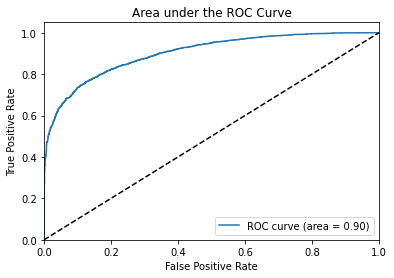

''

In [156]:
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()
;

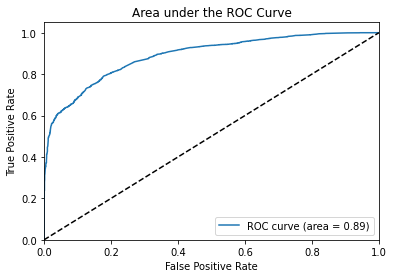

''

In [157]:
predictions = rfModel.transform(testData)

sc = SparkContext.getOrCreate()   # We need to create SparkContext
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()
;

### Both models performed very close. Although Logistic Regression is slightly better, We will further improve the Random Forest classifier.

In [158]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [178]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, range(3, 14, 2))
             .addGrid(rf.numTrees, range(100, 301, 100))
             .build())

cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=7)

In [179]:
cvModel = cv.fit(trainingData)

In [219]:
print("max depth:", cvModel.bestModel.getMaxDepth())
print("numTrees:", cvModel.bestModel.getNumTrees)

max depth: 13
numTrees: 300


### Both of the best parameters are at the end of the ranges. We should continue to search for better hyperparameters, but for the sake of this notebook I will continue.

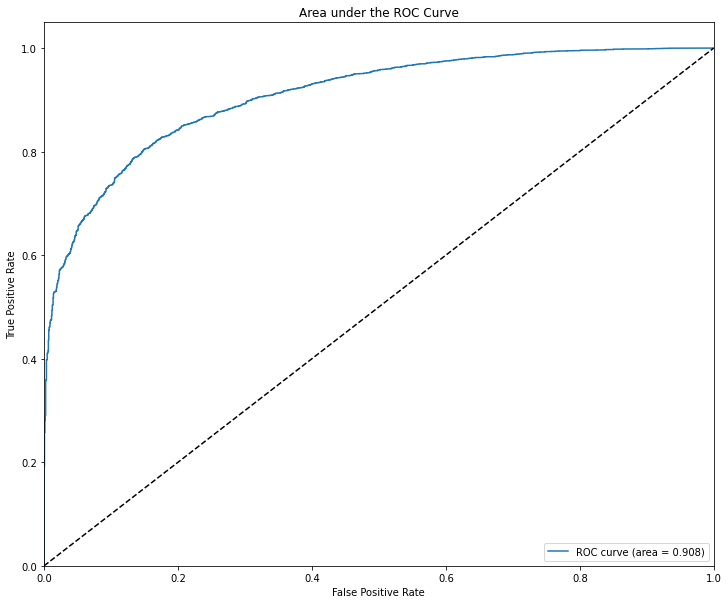

''

In [181]:
predictions = cvModel.transform(testData)

sc = SparkContext.getOrCreate()   # We need to create SparkContext
results = predictions.select(['probability', 'label'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,10))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()
;

In [185]:
results = predictions.select(['label', 'prediction'])
 
## prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0]), float(i[1])) for i in results_collect]
 
y_test = [i[0] for i in results_list]
y_pred = [i[1] for i in results_list]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      5083
         1.0       0.76      0.57      0.65      1710

    accuracy                           0.85      6793
   macro avg       0.82      0.75      0.78      6793
weighted avg       0.84      0.85      0.84      6793



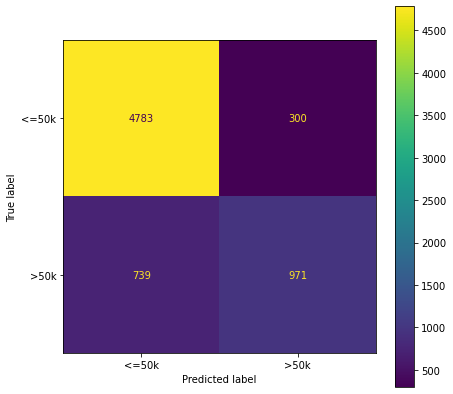

In [195]:
fig, ax = plt.subplots(figsize=(7,7))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<=50k", ">50k"])

disp.plot(ax=ax)

### Compare base Random Forest model with tuned Random Forest model

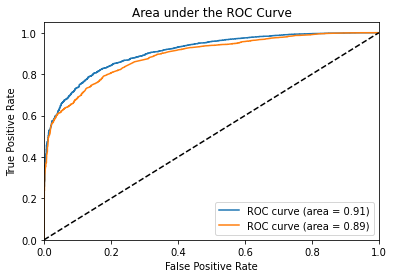

''

In [202]:
plt.figure()

for model in [cvModel.bestModel, rfModel]:
  predictions = model.transform(testData)

  sc = SparkContext.getOrCreate()   # We need to create SparkContext
  results = predictions.select(['probability', 'label'])
  
  ## prepare score-label set
  results_collect = results.collect()
  results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  
  y_test = [i[1] for i in results_list]
  y_score = [i[0] for i in results_list]
  
  fpr, tpr, _ = roc_curve(y_test, y_score)
  roc_auc = auc(fpr, tpr)
  
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()
;